# Previsão de Qualidade do Vinho

Teste realizado para a *cognitivo.ai*, com o objetivo de criar um modelo para estimar a qualidade do vinho, com base em de vinhos portugueses "Vinho Verde", que possuem variantes de vinho branco e tinto. Devido a questões de privacidade, apenas variáveis físico-químicas (input) e sensoriais (output) estão disponíveis (por exemplo, não há dados sobre tipo de uva, marca do vinho, preço de venda, etc).

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import utils

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pickle import dump

## Leitura da base raw

In [2]:
wine_raw_df = pd.read_csv('data-raw/winequality.csv', sep=';')

## Análise dos dados

Vamos observar uma amostra dos dados e seus tipos: 

In [3]:
wine_raw_df.head(10)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
6,White,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6
7,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
8,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
9,White,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11,6


In [4]:
wine_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
type                    6497 non-null object
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null object
quality                 6497 non-null int64
dtypes: float64(10), int64(1), object(2)
memory usage: 659.9+ KB


Temos a variável **type** como categórica, e a **alcohol** que foi lida como categórica mas aparentemente é numérica. Provável problema na consistência dos dados. Podemos presumir que alguns dos valores inconsistentes aparecerão apenas uma vez.

In [5]:
alcohol_counts = wine_raw_df.alcohol.value_counts()
alcohol_counts[alcohol_counts == 1]

105.333.333.333.333    1
114.333.333.333.333    1
14.9                   1
9.05                   1
131.333.333.333.333    1
8.0                    1
11.65                  1
10.65                  1
114.666.666.666.667    1
11.55                  1
956.666.666.666.667    1
10.98                  1
8                      1
11.85                  1
105.666.666.666.667    1
14.05                  1
13.05                  1
11.35                  1
9.75                   1
117.333.333.333.333    1
112.666.666.666.667    1
923.333.333.333.333    1
9.95                   1
963.333.333.333.333    1
12.05                  1
135.666.666.666.667    1
13.55                  1
9.25                   1
123.333.333.333.333    1
113.666.666.666.667    1
10.75                  1
14.2                   1
120.666.666.666.667    1
12.25                  1
Name: alcohol, dtype: int64

Conforme esperado, uma inconsistência nos dados transformou valores numéricos em *string*. Podemos corrigir esse problema:

In [6]:
wine_raw_df['alcohol'] = wine_raw_df['alcohol'].apply(utils.convert_alcohol_str)

Após a correção, a variável é convertida para o tipo certo:

In [7]:
wine_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
type                    6497 non-null object
fixed acidity           6497 non-null float64
volatile acidity        6497 non-null float64
citric acid             6497 non-null float64
residual sugar          6497 non-null float64
chlorides               6497 non-null float64
free sulfur dioxide     6497 non-null float64
total sulfur dioxide    6497 non-null float64
density                 6497 non-null float64
pH                      6497 non-null float64
sulphates               6497 non-null float64
alcohol                 6497 non-null float64
quality                 6497 non-null int64
dtypes: float64(11), int64(1), object(1)
memory usage: 659.9+ KB


## Verificando o a distribuição da resposta (**quality**):

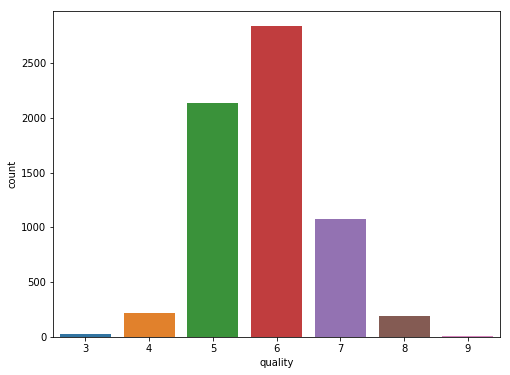

In [8]:
plt.figure(figsize=(8, 6))
sns.countplot(x='quality', data=wine_raw_df);

Variável lida como numérica, porém seus valores são discretos e ordinais, compreendidos no conjunto {3, 4, 5, 6, 7, 8, 9}

## Distribuição

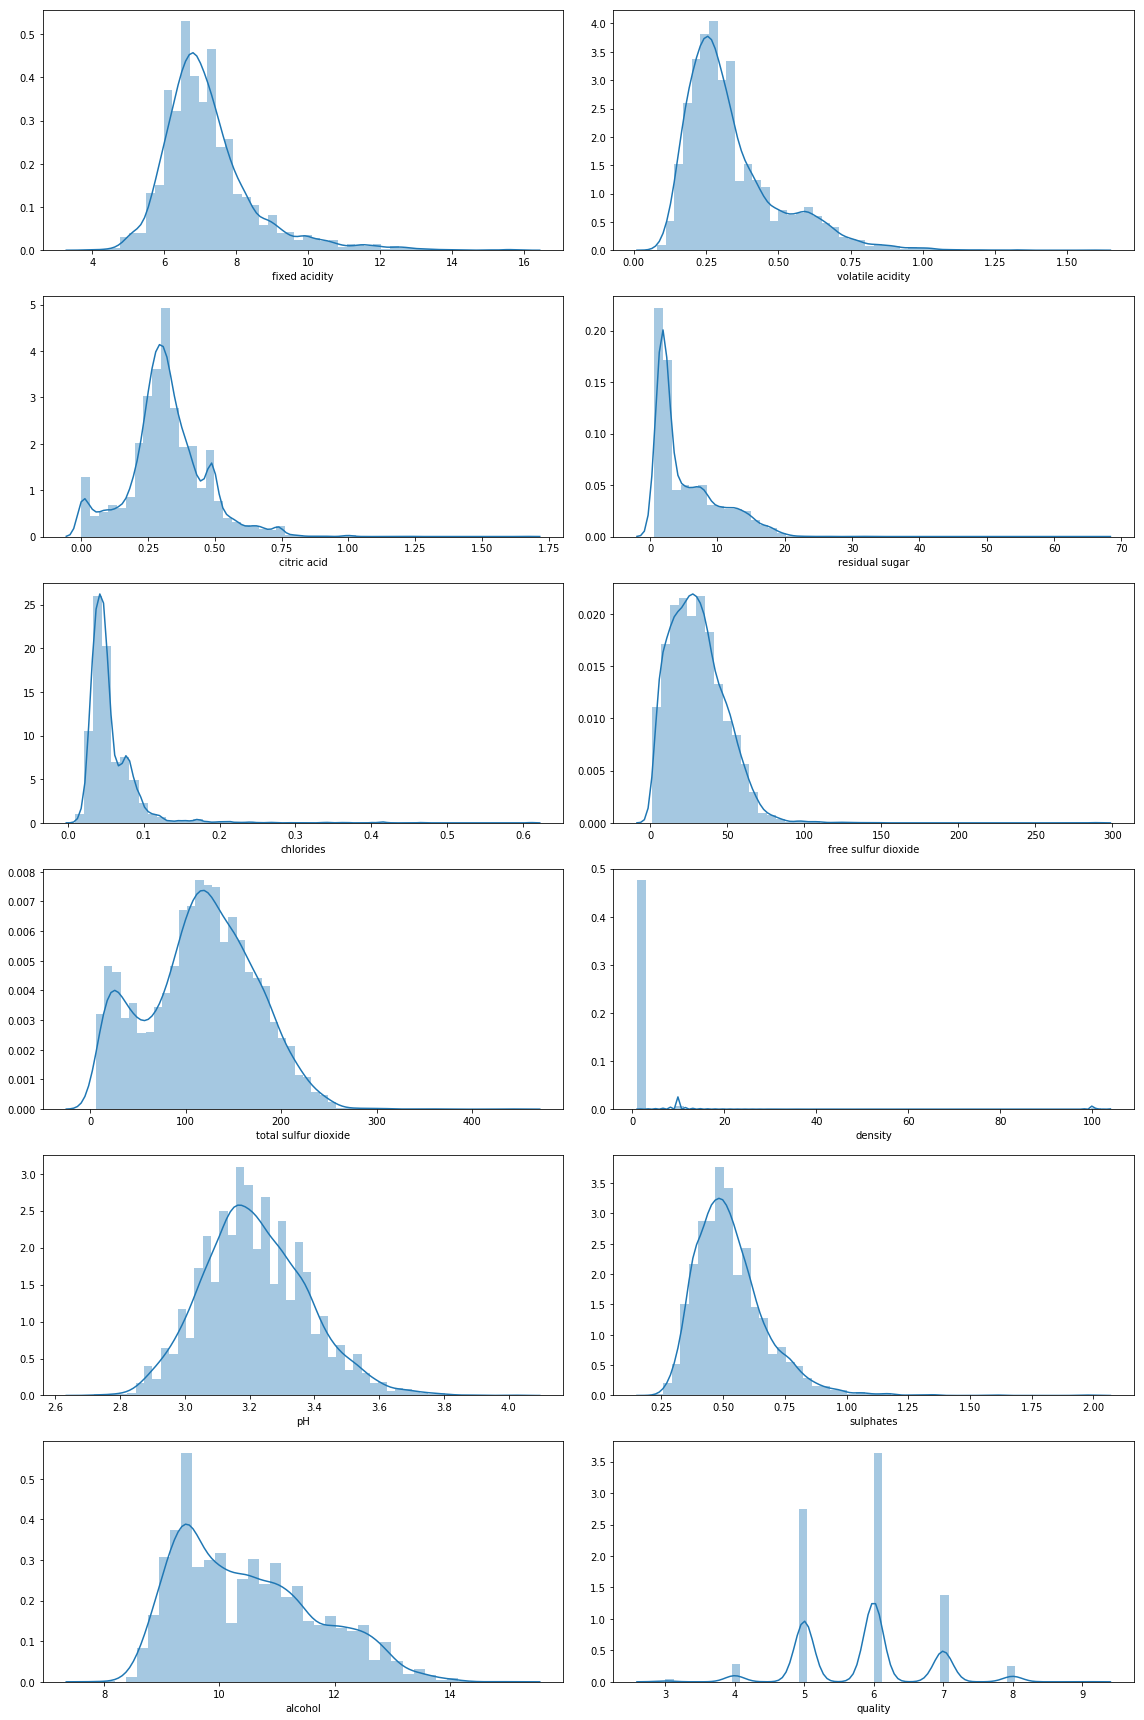

<Figure size 432x288 with 0 Axes>

In [9]:
target = [col for col in wine_raw_df.columns if col != 'type']
utils.univariate_plot(ncol=2, nrow=6, data=wine_raw_df, target=target)

A maioria das variáveis segue uma distribuição gaussiana unimodal, porém assimétrica. Como a maioria dos modelos assume que os preditores possuem uma distribuição normal, devemos aplicar algumas transformações antes de inputar os dados no treinamento.

## Correlação

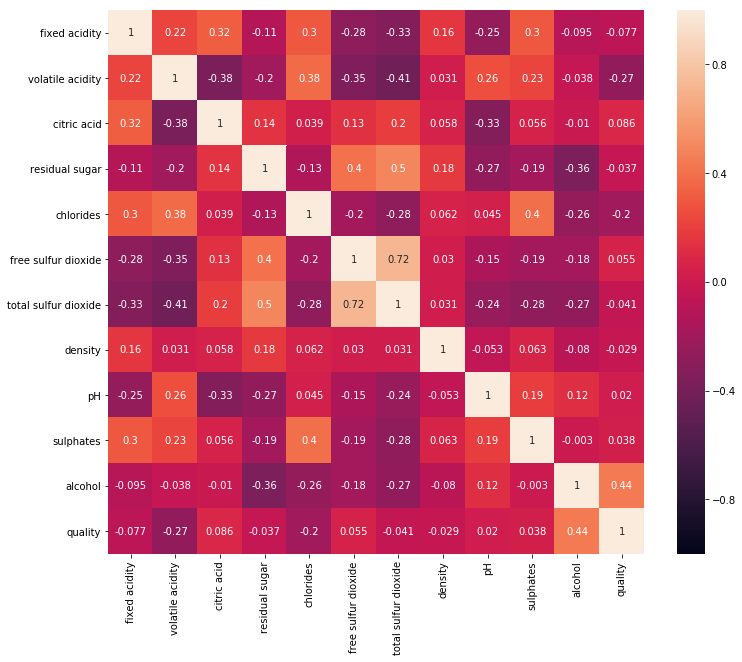

In [10]:
plt.figure(figsize=(12, 10))
sns.heatmap(wine_raw_df.corr(), annot=True, linewidths=0, vmin=-1);

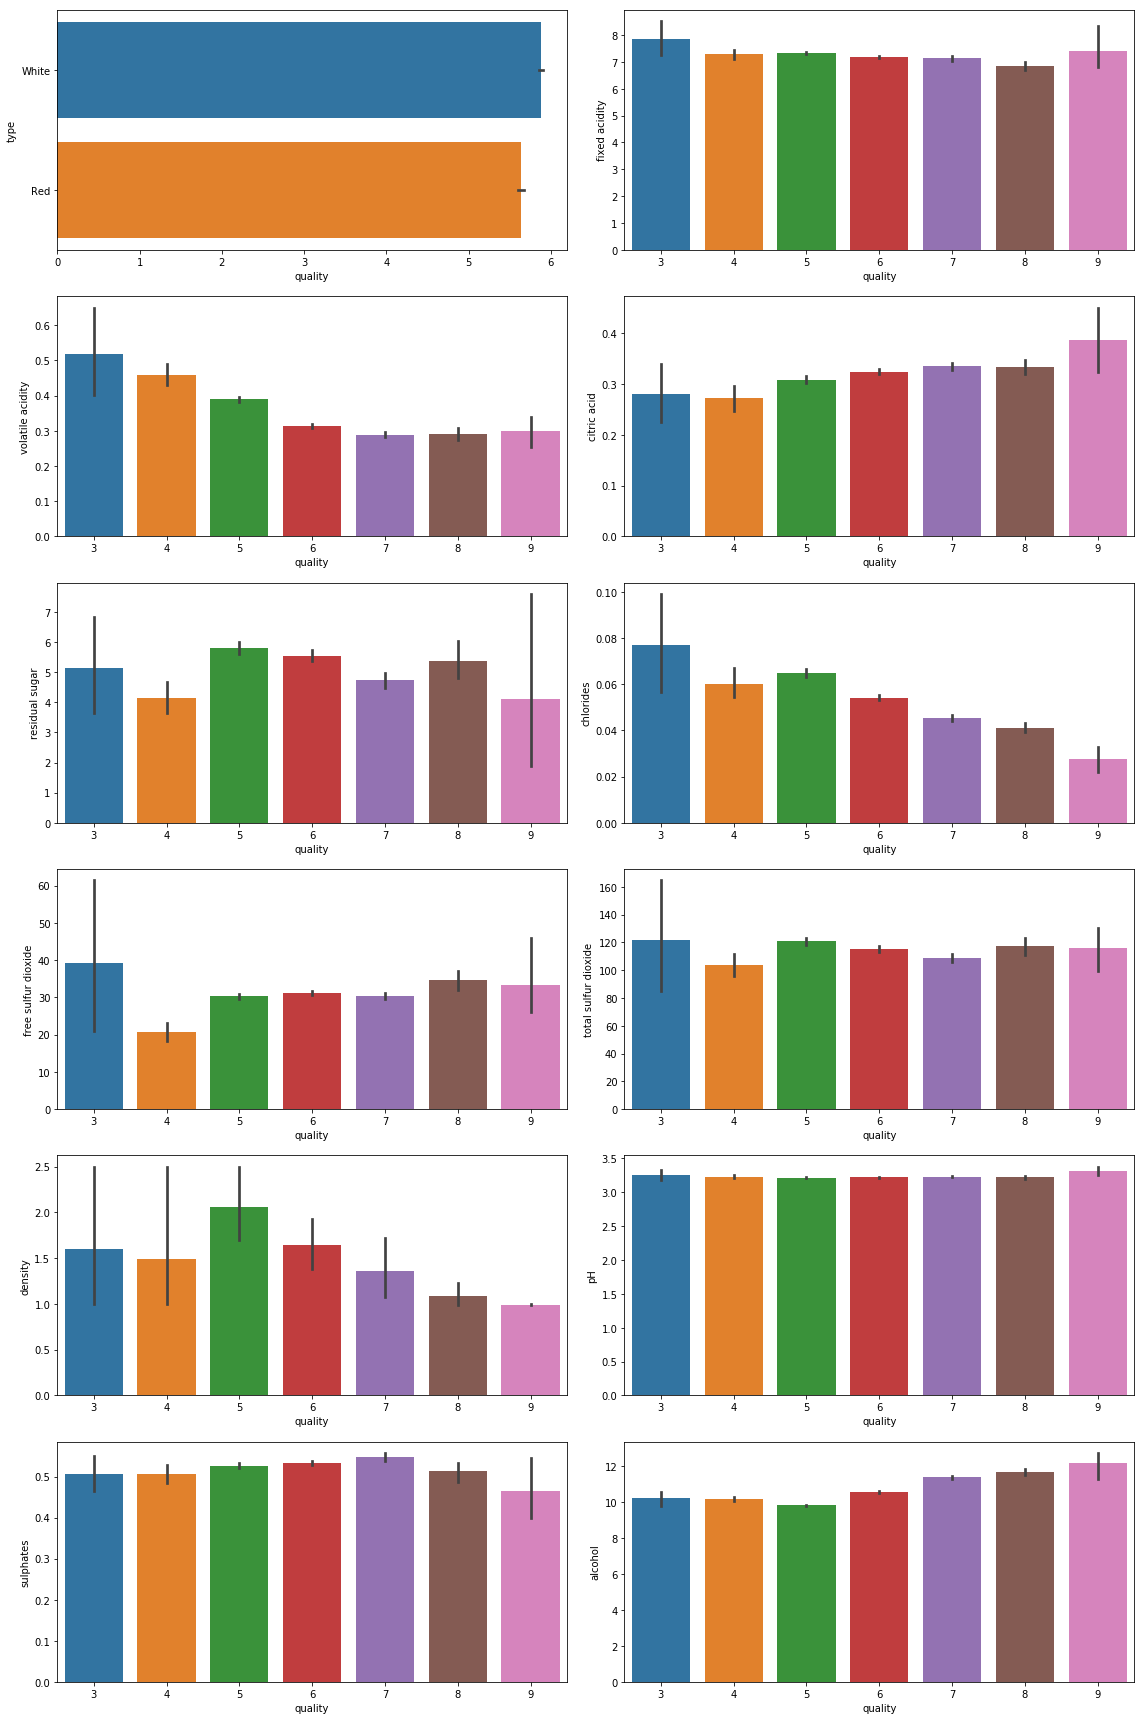

<Figure size 432x288 with 0 Axes>

In [11]:
utils.bivariate_plot(ncol=2, nrow=6, data=wine_raw_df, target='quality')

As maiores correlações preditor x resposta foram encontradas em **alcohol**, **volatile acidity** e **chlorides**. Dentre as variáveis disponíveis, teor alcóolico e acidez no olfato certamente interferem na percepção subjetiva de qualidade, de maneira mais destacada do que diferenças em pH, densidade e outras propriedades. Faz sentido que sejam os maiores valores correlacionados com a qualidade na nossa base de dados.

Existe uma alta correlação entre **free sulfur dioxide** e **total sulfur dioxide**, e outras correlações de menor valor entre outros preditores. Isso afeta modelos de regressão, deve-se usar regularização ou seleção de variáveis nesse caso.

## Salvando base com alcohol corrigido

In [12]:
with open('data/wine_quality_fixed.pkl', 'wb') as file:
    dump(wine_raw_df, file)